In [1020]:
import pandas as pd
from linearmodels import PanelOLS
import numpy as np

def prepare_data():
    """Prepare data for regression analysis"""
    filepath = r'at.dta'
    df = pd.read_stata(filepath)
    df = df.set_index(['app_num', 'ym'])
    df['AFTER_BAN'] = (df.index.get_level_values('ym') >= 716).astype(int)
    df['TREATXAFTER_BAN'] = df['ann_TREAT'] * df['AFTER_BAN']
    return df

def generate_summary_statistics(data):
    """Generate summary statistics for main variables"""
    variables = ['Rating', 'Log_Demand', 'Age', 'Price',
                 'Log_Firm_Size', 'One_Employee']
    
    summary_stats = data[variables].agg(['mean', 'std', 'min', 'median', 'max']).T
    summary_stats.columns = ['Mean', 'Std Dev', 'Min', 'Median', 'Max']
    
    return summary_stats

def run_panel_ols(data, model_type='full'):
    """Run panel OLS regression"""
    Y = data['Rating']
    
    if model_type == 'simple':
        X = data[['TREATXAFTER_BAN', 'genre_cons']]
    else:  # full model
        X = data[['TREATXAFTER_BAN', 'genre_cons', 'Log_Demand', 
                  'Price', 'Log_Firm_Size', 'One_Employee', 'Age']]
    
    model = PanelOLS(Y, X, entity_effects=True, time_effects=True)
    results = model.fit(cov_type='clustered', cluster_entity=True)
    
    return results

def main():
    df = prepare_data()

    # Run summary statistics
    summary_stats = generate_summary_statistics(df)
    print("Summary Statistics:")
    print(summary_stats)
    
    # Run simple model
    simple_results = run_panel_ols(df, model_type='simple')
    print("\nSimple Model Results:")
    print(simple_results)
    
    # Run full model
    full_results = run_panel_ols(df, model_type='full')
    print("\nFull Model Results:")
    print(full_results)
    
    return summary_stats, simple_results, full_results, df

if __name__ == "__main__":
    summary_stats, simple_results, full_results, df = main()

Summary Statistics:
                     Mean     Std Dev       Min      Median          Max
Rating           4.061931    0.522589  1.000000    4.100000     5.000000
Log_Demand       6.308229    3.208901  0.000000    6.426488    15.716231
Age            696.624329  613.680298  1.000000  489.000000  3639.000000
Price            0.004623    0.067865  0.000000    0.000000     1.000000
Log_Firm_Size    2.554413    1.227991  0.693147    2.484907     7.239215
One_Employee     0.859508    0.347312  0.000000    1.000000     1.000000

Simple Model Results:
                          PanelOLS Estimation Summary                           
Dep. Variable:                 Rating   R-squared:                        0.0014
Estimator:                   PanelOLS   R-squared (Between):             -0.0056
No. Observations:               93428   R-squared (Within):              -0.0182
Date:                Sun, Nov 03 2024   R-squared (Overall):             -0.0061
Time:                        23:50:08   L

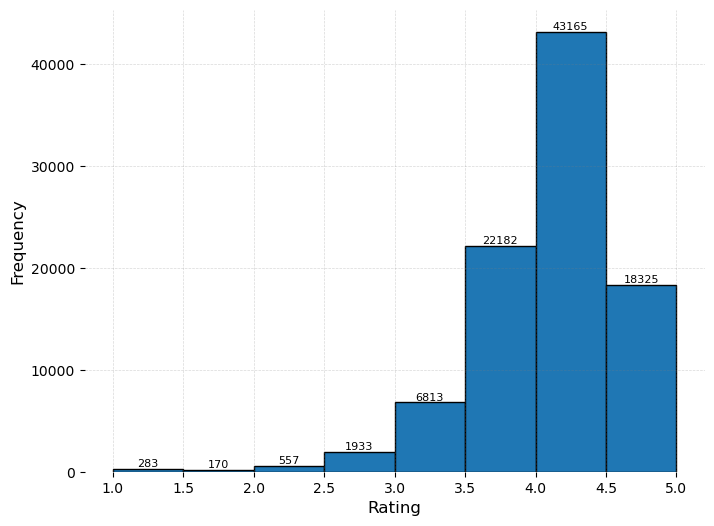

In [268]:
import matplotlib.pyplot as plt
import numpy as np

bins = np.arange(1, 5.5, 0.5)
plt.figure(figsize=(8, 6))

# Plot the histogram and save the patches for the bars
n, bins, patches = plt.hist(df['Rating'], bins=bins, color='#1f77b4', edgecolor='black', linewidth=1)

# Add value labels above each bar, centered over each bar
for patch in patches:
    # Get the bar's center
    height = patch.get_height()
    x = patch.get_x() + patch.get_width() / 2  # Center of the bar
    plt.text(x, height, str(int(height)), ha='center', va='bottom', fontsize=8)

plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(bins, fontsize=10)
plt.yticks(fontsize=10)

# Custom grid function to avoid lines passing through the bars
def custom_grid(ax, which='major'):
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()

    for x in xticks:
        if x >= xmin and x <= xmax:
            ax.axvline(x, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    for y in yticks:
        if y >= ymin and y <= ymax:
            ax.axhline(y, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

plt.grid(False)  # Turn off the default grid
custom_grid(plt.gca())
plt.box(on=None)

plt.savefig('distribution_of_game_ratings.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

Plot saved to: C:\Users\azraj\OneDrive\Desktop\MA Economics\Fall Term\Causal ML\AdBanImpact\Figures\genre_distribution.png


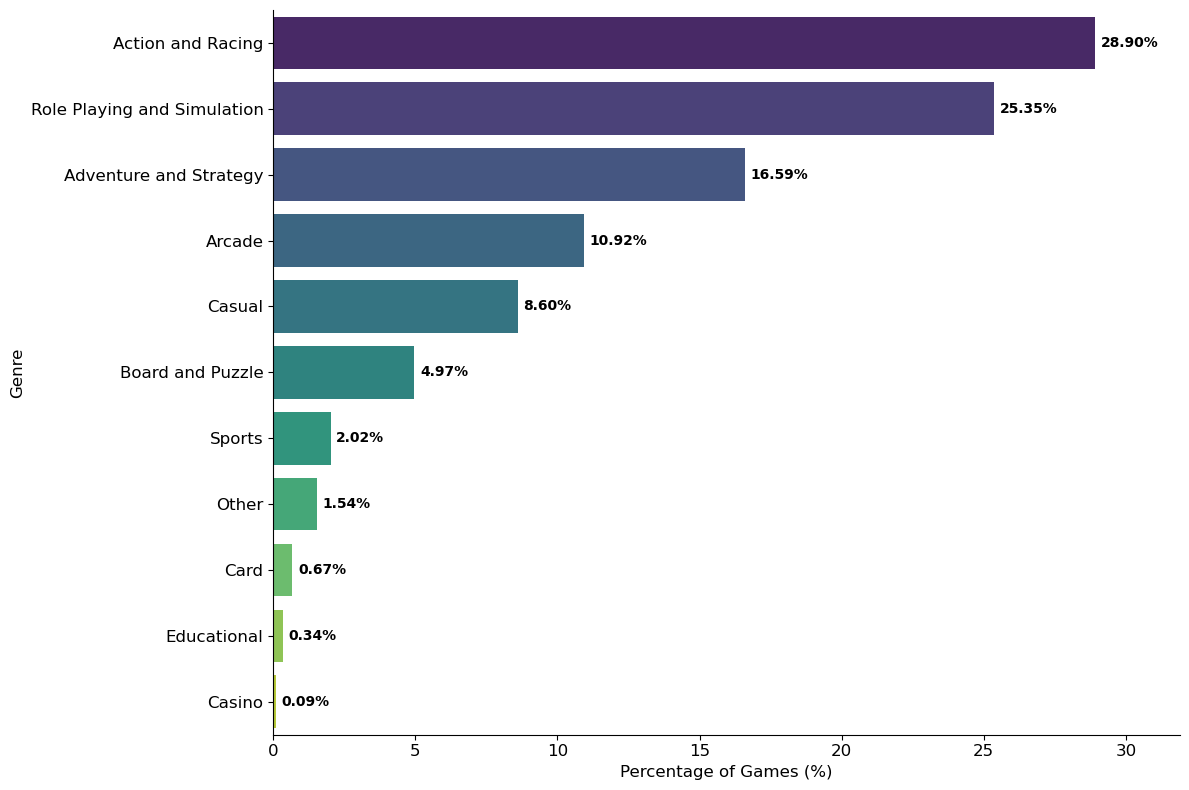

In [456]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_genre_distribution(df, save_path):
    """
    Calculate and plot the distribution of game genres with adaptive label placement.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the genre_cons column
    save_path (str): Directory path to save the figure
    
    Returns:
    pd.Series: Genre distribution percentages
    """
    # Calculate genre distribution
    unique_games = df.reset_index().drop_duplicates(subset='app_num')
    genre_counts = unique_games['genre_cons'].value_counts()
    genre_percentages = (genre_counts / len(unique_games) * 100).round(2)
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Create horizontal bar plot
    ax = sns.barplot(x=genre_percentages.values,
                     y=genre_percentages.index,
                     palette='viridis')
    
    # Customize plot
    plt.xlabel('Percentage of Games (%)', fontsize=12)
    plt.ylabel('Genre', fontsize=12)

    # Increase size of genre names
    plt.yticks(fontsize=12)  # Increased y-axis label size
    plt.xticks(fontsize=12)  # Slightly increased x-axis label size
    
    # Set x-axis limit to include all labels
    plt.xlim(0, max(genre_percentages) + 3)
    
    # Add percentage labels with adaptive placement
    threshold = 5  # Threshold for inside/outside label placement
    
    for i, v in enumerate(genre_percentages.values):
        text_x = v + 0.2
        text_color = 'black'
        ha = 'left'
            
        plt.text(text_x, i, f'{v:.2f}%', 
                va='center',
                ha=ha,
                color=text_color,
                fontweight='bold')
    
    # Remove top and right spines
    sns.despine()
    
    # Adjust layout
    plt.tight_layout()
    
    # Create save directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    
    # Save the plot
    save_file = os.path.join(save_path, 'genre_distribution.png')
    plt.savefig(save_file, 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white',
                edgecolor='none')
    
    print(f"Plot saved to: {save_file}")
    
    return genre_percentages

# Using your existing data
if __name__ == "__main__":
    # Load and prepare data
    df = prepare_data()
    
    # Define save path
    save_path = r"C:\Users\azraj\OneDrive\Desktop\MA Economics\Fall Term\Causal ML\AdBanImpact\Figures"
    
    # Plot and save genre distribution
    genre_percentages = plot_genre_distribution(df, save_path)
    
    plt.show()

In [290]:
import pandas as pd

df = prepare_data()

# Group by app_num and count the instances
app_counts = df.groupby('app_num').size()

# Calculate the average count
average_count = app_counts.mean()

print("Average count of app_num instances:", average_count)

Average count of app_num instances: 17.091875214261226


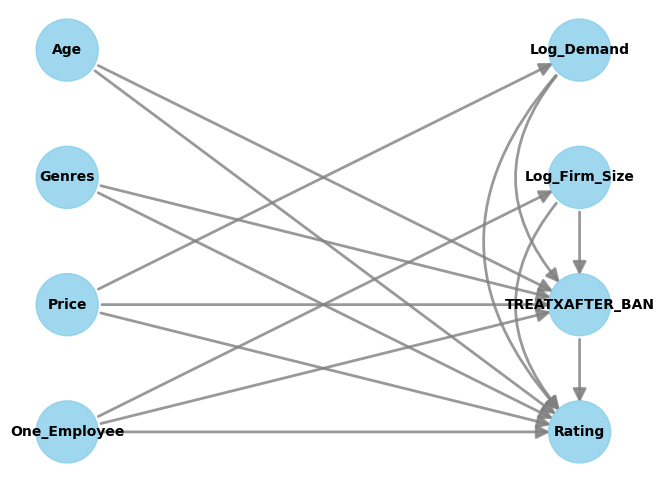

In [180]:
import warnings
from dowhy import CausalModel

# Suppress warnings for better clarity
warnings.filterwarnings("ignore")

# Define treatment and outcome variables
treatment = 'TREATXAFTER_BAN'
outcome = 'Rating'

# Prepare data
df = prepare_data()

# Define the causal model with a clear graph structure
model = CausalModel(
    data=df, 
    treatment=treatment, 
    outcome=outcome, 
    graph="""graph[directed 1
        node[id "Log_Demand" label "Log_Demand"]
        node[id "Age" label "Age"]
        node[id "genre_cons" label "Genres"]
        node[id "Price" label "Price"]
        node[id "One_Employee" label "One_Employee"]
        node[id "Log_Firm_Size" label "Log_Firm_Size"]
        node[id "TREATXAFTER_BAN" label "TREATXAFTER_BAN"]
        node[id "Rating" label "Rating"]
        
        edge[source "Log_Demand" target "TREATXAFTER_BAN"]
        edge[source "Age" target "TREATXAFTER_BAN"]
        edge[source "genre_cons" target "TREATXAFTER_BAN"]
        edge[source "Price" target "TREATXAFTER_BAN"]
        edge[source "One_Employee" target "TREATXAFTER_BAN"]
        edge[source "Log_Firm_Size" target "TREATXAFTER_BAN"]
        
        edge[source "Price" target "Log_Demand"]
        edge[source "One_Employee" target "Log_Firm_Size"]
        
        edge[source "Log_Demand" target "Rating"]
        edge[source "Age" target "Rating"]
        edge[source "genre_cons" target "Rating"]
        edge[source "Price" target "Rating"]
        edge[source "One_Employee" target "Rating"]
        edge[source "Log_Firm_Size" target "Rating"]
        edge[source "TREATXAFTER_BAN" target "Rating"]
    ]
    """
)

# Visualize the causal model
model.view_model()


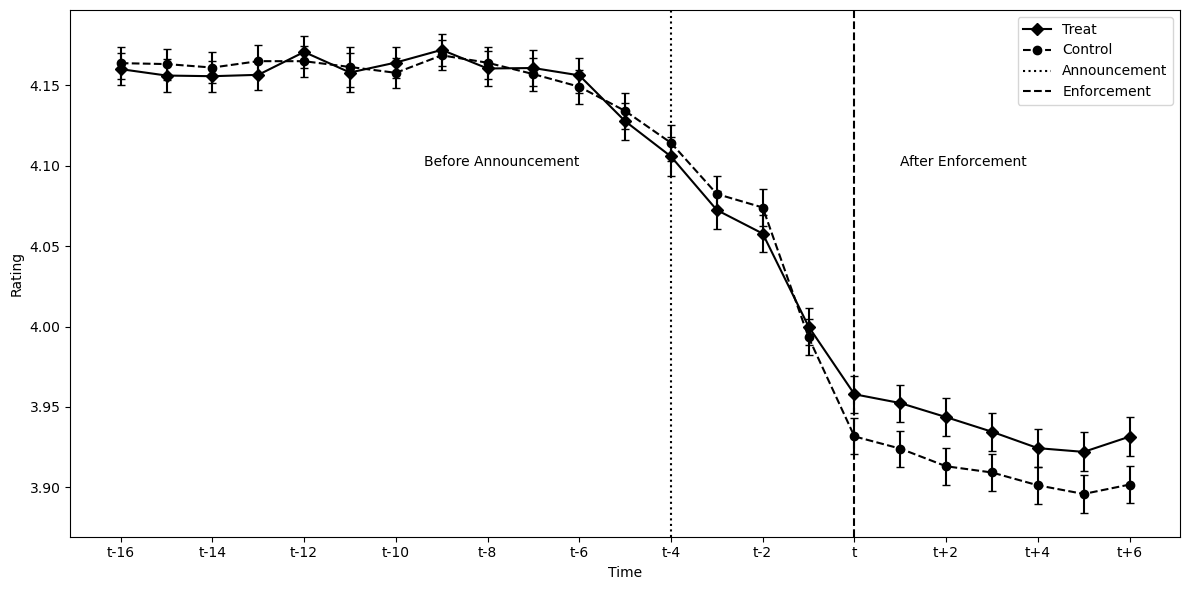

In [286]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
df = prepare_data()

# Calculate the mean Rating and standard error for each group over time
def calc_stats(group):
    return pd.Series({
        'mean': group['Rating'].mean(),
        'se': group['Rating'].sem()
    })

treat_stats = df[df['ann_TREAT'] == 1].groupby('ym').apply(calc_stats).reset_index()
control_stats = df[df['ann_TREAT'] == 0].groupby('ym').apply(calc_stats).reset_index()

# Plot the graph
fig, ax = plt.subplots(figsize=(12, 6))

# Plot lines
ax.plot(treat_stats['ym'], treat_stats['mean'], color='black', linestyle='solid', marker='D', label='Treat')
ax.plot(control_stats['ym'], control_stats['mean'], color='black', linestyle='dashed', marker='o', label='Control')

# Add error bars
ax.errorbar(treat_stats['ym'], treat_stats['mean'], yerr=treat_stats['se'], 
            fmt='none', ecolor='black', capsize=3)
ax.errorbar(control_stats['ym'], control_stats['mean'], yerr=control_stats['se'], 
            fmt='none', ecolor='black', capsize=3)

ax.set_xlabel('Time')
ax.set_ylabel('Rating')

# Adjust x-ticks to span the entire graph with 't' as the benchmark
min_ym = int(min(treat_stats['ym'].min(), control_stats['ym'].min()))
max_ym = int(max(treat_stats['ym'].max(), control_stats['ym'].max()))
benchmark_ym = 716

ym_range = list(range(min_ym, max_ym + 1, 2))  # Adjust step size if needed
labels = [f't{i - benchmark_ym:+d}' if i != benchmark_ym else 't' for i in ym_range]

ax.set_xticks(ym_range)
ax.set_xticklabels(labels)

ax.grid(False)
ax.axvline(712, color='black', linestyle='dotted', label='Announcement')
ax.axvline(716, color='black', linestyle='--', label='Enforcement')
ax.text(710, 4.1, 'Before Announcement', ha='right')
ax.text(717, 4.1, 'After Enforcement', ha='left')
ax.legend()

plt.tight_layout()
# Save as PNG
plt.savefig('fig_rating_did.png', format='png', dpi=300)  # Save as PNG with 300 dpi for better quality

Preparing data...

Running Regression Tree Analysis:
Root Mean Squared Error: 0.4736


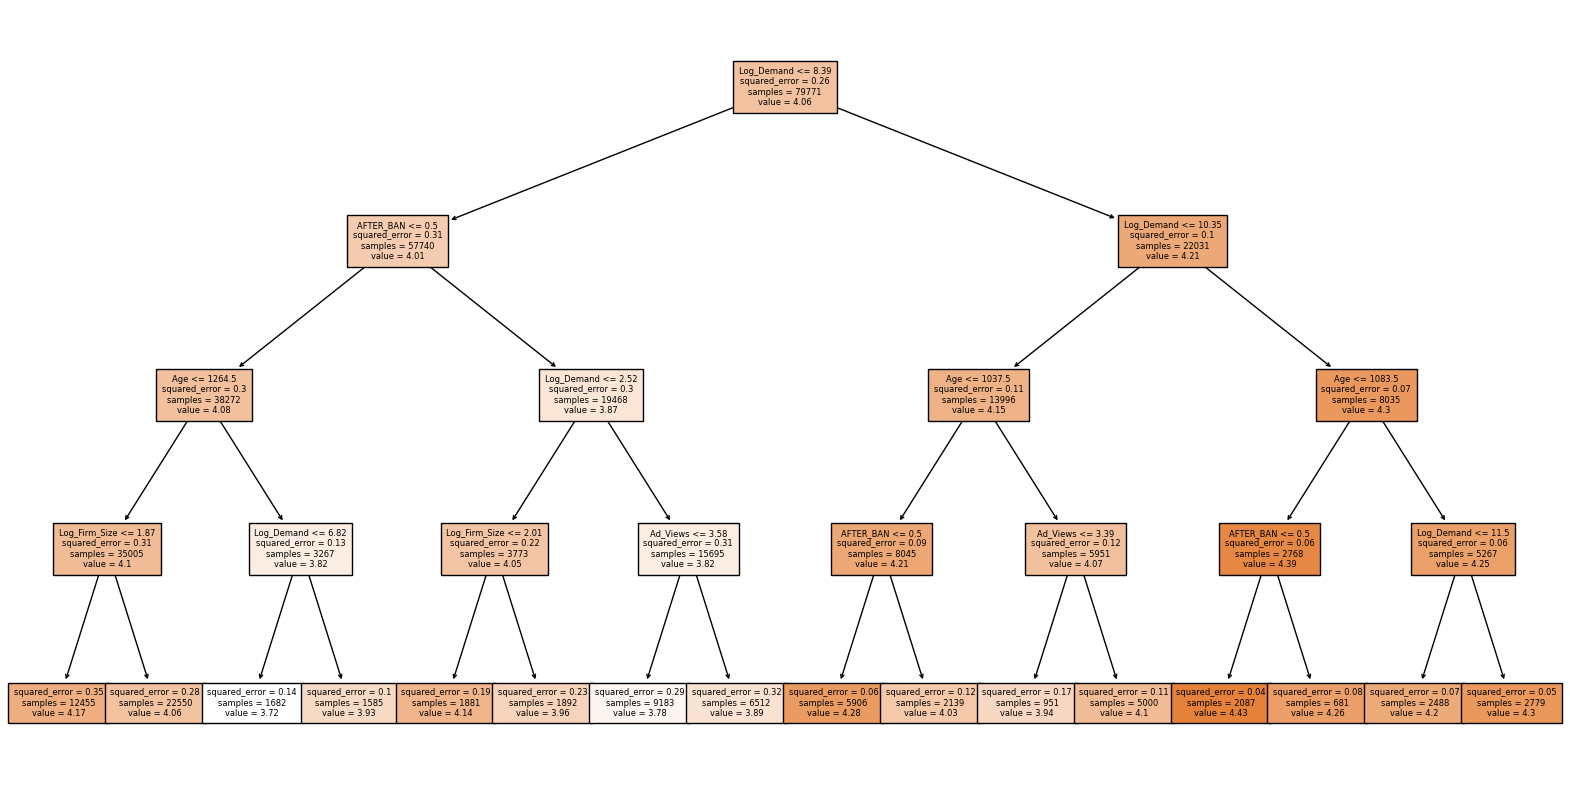

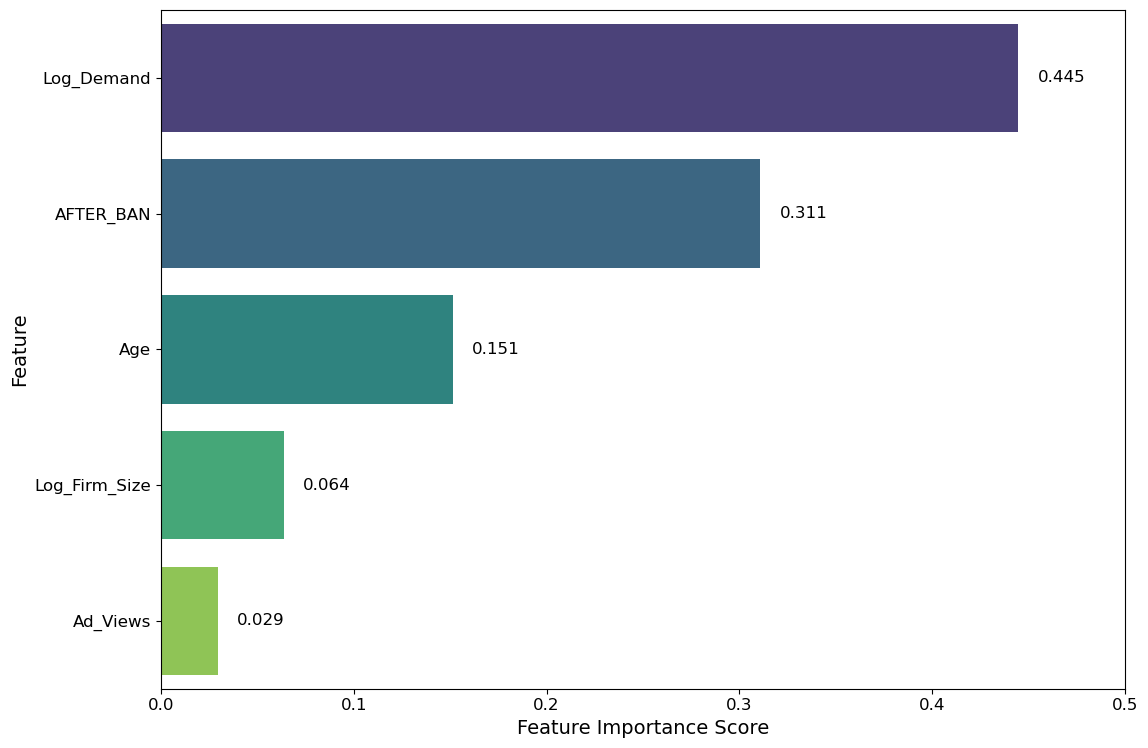


Top 5 Most Important Features:
          feature  importance
9      Log_Demand    0.444817
19      AFTER_BAN    0.310906
2             Age    0.151379
10  Log_Firm_Size    0.063548
1        Ad_Views    0.029351

Plots have been saved to: C:\Users\azraj\OneDrive\Desktop\MA Economics\Fall Term\Causal ML\AdBanImpact\Figures


In [1001]:
import os
import pandas as pd
import numpy as np
from linearmodels import PanelOLS
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Set the path to save the figures
figures_path = r"C:\Users\azraj\OneDrive\Desktop\MA Economics\Fall Term\Causal ML\AdBanImpact\Figures"
os.makedirs(figures_path, exist_ok=True)

def prepare_data():
    """Prepare data for regression and tree analysis"""
    filepath = r'at.dta'
    df = pd.read_stata(filepath)
    df = df.set_index(['app_num', 'ym'])
    df['AFTER_BAN'] = (df.index.get_level_values('ym') >= 716).astype(int)
    df['TREATXAFTER_BAN'] = df['ann_TREAT'] * df['AFTER_BAN']
    return df

def prepare_tree_data(df):
    """Prepare features for decision tree analysis"""
    tree_df = df.reset_index()
    
    feature_columns = [
        'Ad_Networks', 'Ad_Views', 'Age', 'Bug_Fix',
        'Collects_User_ID', 'Feature_Update', 'Feature_Update_lag', 
        'Feature_Updates', 'File_Size', 'Log_Demand', 
        'Log_Firm_Size', 'One_Employee', 'Permissions', 
        'Price', 'Undiversified', 'Update', 'Young', 'ann_TREAT', 
        'collected_id', 'genre_cons', 
        'AFTER_BAN', 'TREATXAFTER_BAN'
    ]
    
    X = tree_df[feature_columns].copy()
    y = tree_df['Rating']
    
    # Handle categorical variables
    X = pd.get_dummies(X, columns=['genre_cons'], drop_first=True)
    
    # Fill missing values
    X = X.fillna(X.mean())
    y = y.fillna(y.mean())
    
    # Convert any remaining object columns to numeric
    for col in X.columns:
        if X[col].dtype == 'object':
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, X.columns.tolist()

def run_regression_tree(X_train, X_test, y_train, y_test, feature_names):
    """Run and evaluate regression tree"""
    tree_model = DecisionTreeRegressor(max_depth=4, min_samples_leaf=50)
    tree_model.fit(X_train, y_train)
    
    y_pred_tree = tree_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_tree)
    rmse = np.sqrt(mse)
    print(f'Root Mean Squared Error: {rmse:.4f}')
    
    plt.figure(figsize=(20, 10))
    plot_tree(tree_model, feature_names=feature_names, filled=True, 
              fontsize=6, precision=2)
    
    # Save the decision tree plot
    tree_plot_path = os.path.join(figures_path, 'regression_tree_plot.png')
    plt.savefig(tree_plot_path, bbox_inches='tight', dpi=300)
    plt.show()
    
    return tree_model

def analyze_tree_importance(tree_model, feature_names):
    """Analyze and plot feature importance from tree model"""
    importances = tree_model.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    # Plot top 5 most important features
    plt.figure(figsize=(12, 8))  # Adjust the figure size to make the bars larger
    top_features = feature_importance.head(5)
    sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
    
    plt.xlabel('Feature Importance Score', fontsize=14)  # Increase font size
    plt.ylabel('Feature', fontsize=14)  # Increase font size

    current_xlim = plt.gca().get_xlim()
    plt.xlim(current_xlim[0], 0.5)  # Adjust the x-axis limit
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    
    # Add value labels on the bars
    for i, v in enumerate(top_features['importance']):
        plt.text(v + 0.01, i, f'{v:.3f}', va='center', ha='left', fontsize=12)  # Increase text size
    
    plt.tight_layout()
    
    # Save the feature importance plot
    plt.savefig('feature_importance_plot.png', bbox_inches='tight', dpi=300)
    plt.savefig(os.path.join(figures_path, 'feature_importance_plot.png'), bbox_inches='tight', dpi=300)
    plt.show()
    
    print("\nTop 5 Most Important Features:")
    print(top_features)
    return feature_importance


def main():
    print("Preparing data...")
    df = prepare_data()
    X_train, X_test, y_train, y_test, feature_names = prepare_tree_data(df)
    
    print("\nRunning Regression Tree Analysis:")
    reg_tree = run_regression_tree(X_train, X_test, y_train, y_test, feature_names)
    reg_importance = analyze_tree_importance(reg_tree, feature_names)
    
    print("\nPlots have been saved to:", figures_path)
    return df, reg_tree, reg_importance

if __name__ == "__main__":
    df, reg_tree, reg_importance = main()


Preparing data...

Running Random Forest Analysis:

Random Forest Model Performance:
Root Mean Squared Error: 0.4648
R-squared Score: 0.1411


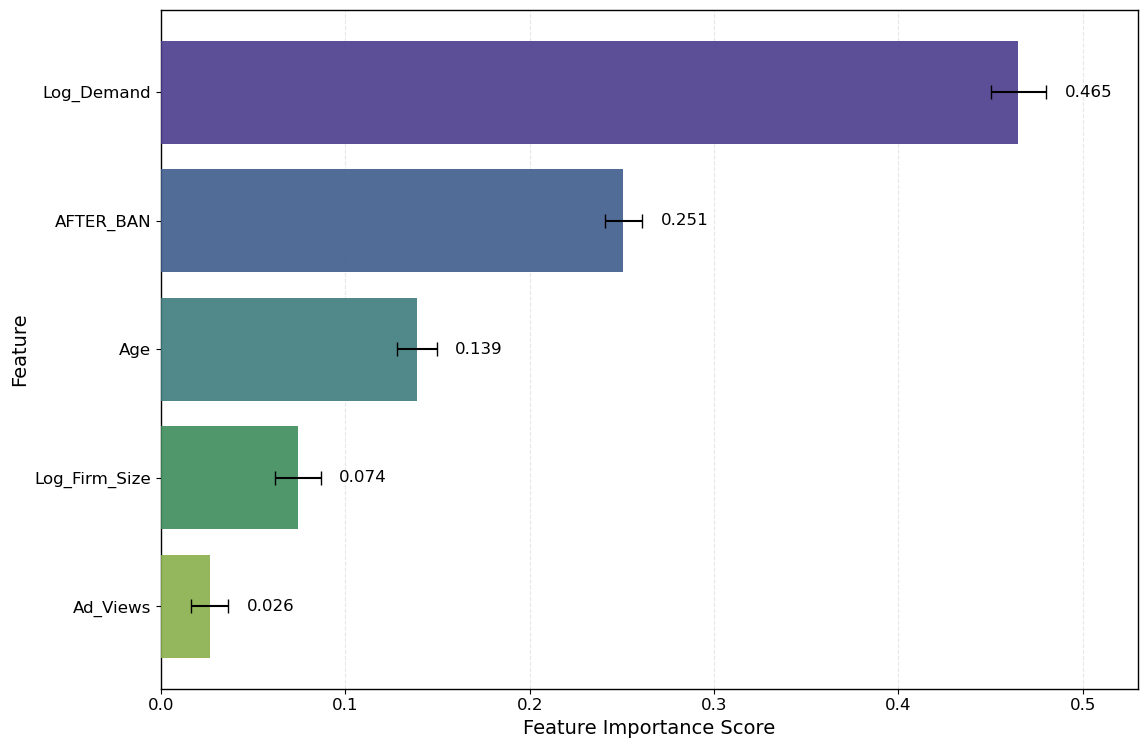

In [998]:
import pandas as pd
import numpy as np
from linearmodels import PanelOLS
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")

def prepare_data():
    """Prepare data for regression and tree analysis"""
    filepath = r'at.dta'
    df = pd.read_stata(filepath)
    df = df.set_index(['app_num', 'ym'])
    df['AFTER_BAN'] = (df.index.get_level_values('ym') >= 716).astype(int)
    df['TREATXAFTER_BAN'] = df['ann_TREAT'] * df['AFTER_BAN']
    return df

def prepare_tree_data(df):
    """Prepare features for tree-based analysis"""
    tree_df = df.reset_index()
    
    feature_columns = [
        'Ad_Networks', 'Ad_Views', 'Age', 'Bug_Fix',
        'Collects_User_ID', 'Feature_Update', 'Feature_Update_lag', 
        'Feature_Updates', 'File_Size', 'Log_Demand', 
        'Log_Firm_Size', 'One_Employee', 'Permissions', 
        'Price', 'Undiversified', 'Update', 'Young', 'ann_TREAT', 
        'collected_id', 'genre_cons', 
        'AFTER_BAN', 'TREATXAFTER_BAN'
    ]
    
    X = tree_df[feature_columns].copy()
    y = tree_df['Rating']
    
    # Handle categorical variables
    X = pd.get_dummies(X, columns=['genre_cons'], drop_first=True)
    
    # Fill missing values
    X = X.fillna(X.mean())
    y = y.fillna(y.mean())
    
    # Convert any remaining object columns to numeric
    for col in X.columns:
        if X[col].dtype == 'object':
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, X.columns.tolist()

def run_random_forest(X_train, X_test, y_train, y_test, feature_names):
    """Run and evaluate random forest model"""
    # Initialize Random Forest with parameters
    rf_model = RandomForestRegressor(
        n_estimators=100,  # number of trees
        max_depth=5,       # maximum depth of trees
        min_samples_leaf=30,  # minimum samples required at leaf node
        n_jobs=-1,        # use all available cores
        random_state=42
    )
    
    # Fit the model
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_rf = rf_model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred_rf)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_rf)
    
    print("\nRandom Forest Model Performance:")
    print(f'Root Mean Squared Error: {rmse:.4f}')
    print(f'R-squared Score: {r2:.4f}')
    
    return rf_model

def custom_grid(ax):
    """Add custom grid lines that pass through the bars"""
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()
    
    # Add vertical lines
    for x in xticks:
        if x >= xmin and x <= xmax:
            ax.axvline(x, color='gray', linestyle='--', linewidth=0.5, alpha=0.2, zorder=1)
    
    # Add horizontal lines
    for y in yticks:
        if y >= ymin and y <= ymax:
            ax.axhline(y, color='gray', linestyle='--', linewidth=0.5, alpha=0.2, zorder=1)

def analyze_forest_importance(rf_model, feature_names, save_path=r'C:\Users\azraj\OneDrive\Desktop\MA Economics\Fall Term\Causal ML\AdBanImpact\Figures'):
    """Feature importance plot with size matching the decision tree plot"""
    importances = rf_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

    # Create DataFrame for feature importances
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances,
        'Std': std
    }).sort_values('Importance', ascending=False).head(5)
    
    # Create figure first (like in decision tree plot)
    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    
    # Define colors for gradient
    colors = ['#4B3C8C', '#3E5C8C', '#3E7C7D', '#3E8C5C', '#88B04B']
    
    # Plot bars
    bars = ax.barh(
        range(len(feature_importance)), 
        feature_importance['Importance'],
        xerr=feature_importance['Std'],
        color=colors,
        ecolor='black',
        capsize=5,
        alpha=0.9,
        height=0.8,  # Match seaborn's bar height
        zorder=3
    )
    
    # Set y-ticks
    ax.set_yticks(range(len(feature_importance)))
    ax.set_yticklabels(feature_importance['Feature'])
    
    # Invert y-axis to show highest importance on top
    ax.invert_yaxis()
    
    # Set x-axis limit to match
    ax.set_xlim(0, 0.53)
    
    # Add value annotations with increased offset
    for i, (importance, std) in enumerate(zip(feature_importance['Importance'], feature_importance['Std'])):
        ax.text(
            importance + std + 0.01,
            i,
            f'{importance:.3f}',
            va='center',
            ha='left',
            fontsize=12
        )
    
    # Customize appearance
    ax.set_xlabel('Feature Importance Score', fontsize=14)
    ax.set_ylabel('Feature', fontsize=14)
    
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    
    # Show all spines for box frame
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.0)
    
    # Add gridlines
    ax.grid(axis='x', linestyle='--', alpha=0.3, zorder=0)
   
    
    # Use tight_layout like in decision tree plot
    plt.tight_layout()
    
    # Save the figure
    save_filename = os.path.join(save_path, 'rf_feature_importance_plot.png')
    plt.savefig(save_filename, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return feature_importance
    
def main():
    print("Preparing data...")
    df = prepare_data()
    X_train, X_test, y_train, y_test, feature_names = prepare_tree_data(df)
    
    print("\nRunning Random Forest Analysis:")
    rf_model = run_random_forest(X_train, X_test, y_train, y_test, feature_names)
    rf_importance = analyze_forest_importance(rf_model, feature_names)
    
    return df, rf_model, rf_importance

if __name__ == "__main__":
    df, rf_model, rf_importance = main()

In [426]:
import pandas as pd
import numpy as np
from linearmodels import PanelOLS
import statsmodels.api as sm
import warnings

# Suppress warnings for better clarity
warnings.filterwarnings("ignore")

def run_panel_regressions(df):
    # Convert ym to datetime for panel data structure
    df = df.copy()
    
    # Filter condition (preban period)
    mask = (df['ym'] <= 716) & (df['ym'] > 710)
    df_filtered = df[mask].copy()
    
    # Create MultiIndex before creating dummies
    df_filtered = df_filtered.set_index(['app_num', 'ym'])
    
    # Store ann_TREAT before creating dummies
    ann_treat = df_filtered['ann_TREAT']
    
    # Create dummies for time fixed effects (drop first to avoid multicollinearity)
    time_dummies = pd.get_dummies(df_filtered.index.get_level_values('ym'), prefix='time', drop_first=True)
    time_dummies.index = df_filtered.index
    
    # Create genre dummies (drop first to avoid multicollinearity)
    genre_dummies = pd.get_dummies(df_filtered['genre_num'], prefix='genre', drop_first=True)

    # Create interaction terms for t-5 through t-1
    interact_dummies = pd.DataFrame(index=df_filtered.index)
    for i, col in enumerate(time_dummies.columns):
        interact_dummies[f'treat_t_minus_{5-i}'] = time_dummies[col] * ann_treat

    # Add treatment variable and create treat_df
    treat_df = pd.DataFrame({'ann_TREAT': ann_treat}, index=df_filtered.index)

    # Combine all exogenous variables
    exog_data = pd.concat([treat_df, time_dummies, genre_dummies, interact_dummies], axis=1)
    
    # Dependent variables with their model types - reordered and removed Permissions
    dep_vars = {
        'Rating': 'OLS',
        'Log\\_Demand': 'OLS',
        'Price': 'LPM',
        'File\\_Size': 'OLS',
        'Feature\\_Update': 'LPM'
    }
    
    results = []
    
    for dep_var, model_type in dep_vars.items():
        # Run regression
        model = PanelOLS(
            df_filtered[dep_var.replace('\\_', '_')],
            exog_data,
            entity_effects=True,
            time_effects=False,
            check_rank=False
        )
        
        reg_results = model.fit(cov_type='clustered', cluster_entity=True)
        
        # Store results
        coef_data = []
        se_data = []
        
        # Get treatment interaction coefficients and standard errors for t-5 through t-1
        for i in range(5, 0, -1):
            col = f'treat_t_minus_{i}'
            coef = reg_results.params[col]
            se = reg_results.std_errors[col]
            
            # Add stars based on p-value
            p_value = reg_results.pvalues[col]
            stars = ''
            if p_value < 0.001:
                stars = '$^{***}$'
            elif p_value < 0.01:
                stars = '$^{**}$'
            elif p_value < 0.05:
                stars = '$^{*}$'
                
            coef_data.append(f"{coef:.3f}{stars}")
            se_data.append(f"({se:.3f})")
        
        results.append({
            'dep_var': dep_var,
            'model_type': model_type,
            'coefficients': coef_data,
            'std_errors': se_data,
            'n_obs': reg_results.nobs,
            'r2': reg_results.rsquared_within,
            'f_stat': reg_results.f_statistic.stat,
            'f_pvalue': reg_results.f_statistic.pval
        })

    # Create LaTeX table
    latex_table = [
        "\\begin{table}[!htbp]",
        "\\centering",
        "\\caption{Test for the Parallel Trends Assumption}",
        "\\label{tab:parallel_trends}",
        "\\begin{tabular}{l" + "c" * len(dep_vars) + "}",
        "\\toprule"
    ]
    
    # Header row
    header = [''] + [f'({i+1})' for i in range(len(dep_vars))]
    latex_table.append(' & '.join(header) + ' \\\\')
    
    # Variable names and model types
    var_row = [''] + [f'{var}' for var in dep_vars.keys()]
    latex_table.append(' & '.join(var_row) + ' \\\\')
    model_row = [''] + [f'({model_type})' for model_type in dep_vars.values()]
    latex_table.append(' & '.join(model_row) + ' \\\\')
    latex_table.append('\\midrule')
    
    # Coefficient rows
    time_labels = ['Treat $\\times$ t-5', 'Treat $\\times$ t-4', 'Treat $\\times$ t-3', 
                  'Treat $\\times$ t-2', 'Treat $\\times$ t-1']
    
    for i, label in enumerate(time_labels):
        row_coef = [label]
        row_se = ['']
        
        for result in results:
            row_coef.append(result['coefficients'][i])
            row_se.append(result['std_errors'][i])
            
        latex_table.append(' & '.join(row_coef) + ' \\\\')
        latex_table.append(' & '.join(row_se) + ' \\\\')
    
    latex_table.append('\\midrule')
    
    # Statistics rows
    stats = [
        ('Observations', lambda r: str(int(r['n_obs']))),
        ('Game fixed effects', lambda r: 'x'),
        ('Category fixed effects', lambda r: 'x'),
        ('Month fixed effects', lambda r: 'x'),
        ('Adjusted $R^2$', lambda r: f"{r['r2']:.3f}"),
        ('F-statistic', lambda r: f"{r['f_stat']:.2f}" + 
            ('$^{***}$' if r['f_pvalue'] < 0.001 else
             '$^{**}$' if r['f_pvalue'] < 0.01 else
             '$^{*}$' if r['f_pvalue'] < 0.05 else ''))
    ]
    
    for stat_name, stat_func in stats:
        row = [stat_name]
        row.extend([stat_func(r) for r in results])
        latex_table.append(' & '.join(row) + ' \\\\')
    
    # Close table
    latex_table.extend([
        "\\bottomrule",
        "\\end{tabular}",
        "\\begin{tablenotes}",
        "\\small",
        "\\item \\textit{Notes:} Standard errors in parentheses",
        "\\item $^{*}$, $^{**}$, $^{***}$ indicate significance at the 5\\%, 1\\%, and 0.1\\% levels, respectively.",
        "\\end{tablenotes}",
        "\\end{table}"
    ])
    
    return '\n'.join(latex_table)

def main():
    filepath = 'at.dta'
    df = pd.read_stata(filepath)
    table = run_panel_regressions(df)
    print(table)

if __name__ == "__main__":
    main()

\begin{table}[!htbp]
\centering
\caption{Test for the Parallel Trends Assumption}
\label{tab:parallel_trends}
\begin{tabular}{lccccc}
\toprule
 & (1) & (2) & (3) & (4) & (5) \\
 & Rating & Log\_Demand & Price & File\_Size & Feature\_Update \\
 & (OLS) & (OLS) & (LPM) & (OLS) & (LPM) \\
\midrule
Treat $\times$ t-5 & 0.006 & 0.013 & 0.001 & 0.139 & -0.006 \\
 & (0.006) & (0.011) & (0.001) & (0.110) & (0.005) \\
Treat $\times$ t-4 & 0.002 & 0.012 & -0.000 & 0.241 & -0.005 \\
 & (0.007) & (0.014) & (0.001) & (0.138) & (0.006) \\
Treat $\times$ t-3 & 0.001 & 0.026 & -0.001 & 0.168 & -0.005 \\
 & (0.008) & (0.017) & (0.001) & (0.165) & (0.006) \\
Treat $\times$ t-2 & 0.014 & 0.026 & 0.000 & 0.103 & -0.009 \\
 & (0.010) & (0.020) & (0.001) & (0.183) & (0.006) \\
Treat $\times$ t-1 & 0.019 & 0.037 & 0.000 & -0.035 & -0.005 \\
 & (0.011) & (0.022) & (0.001) & (0.188) & (0.006) \\
\midrule
Observations & 30406 & 32876 & 32876 & 31329 & 32086 \\
Game fixed effects & x & x & x & x & x \\
Category 

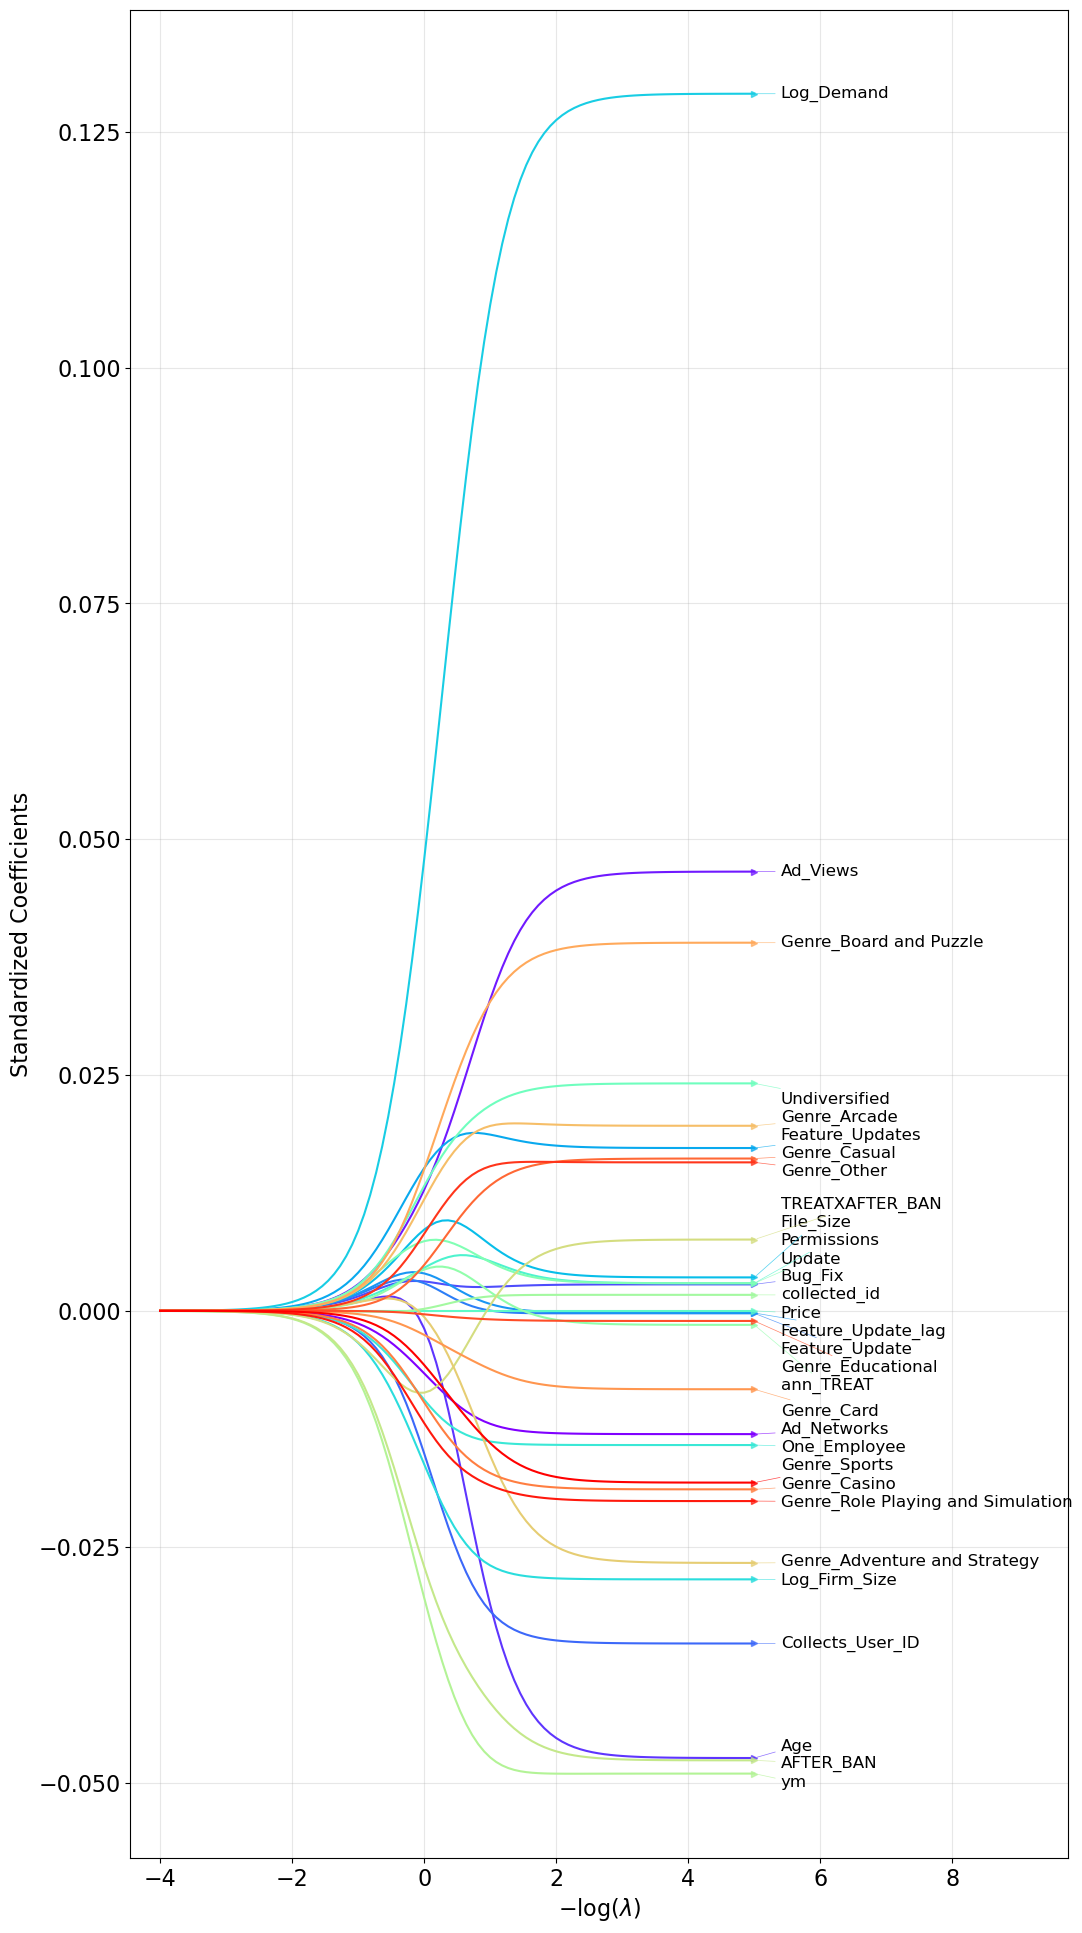

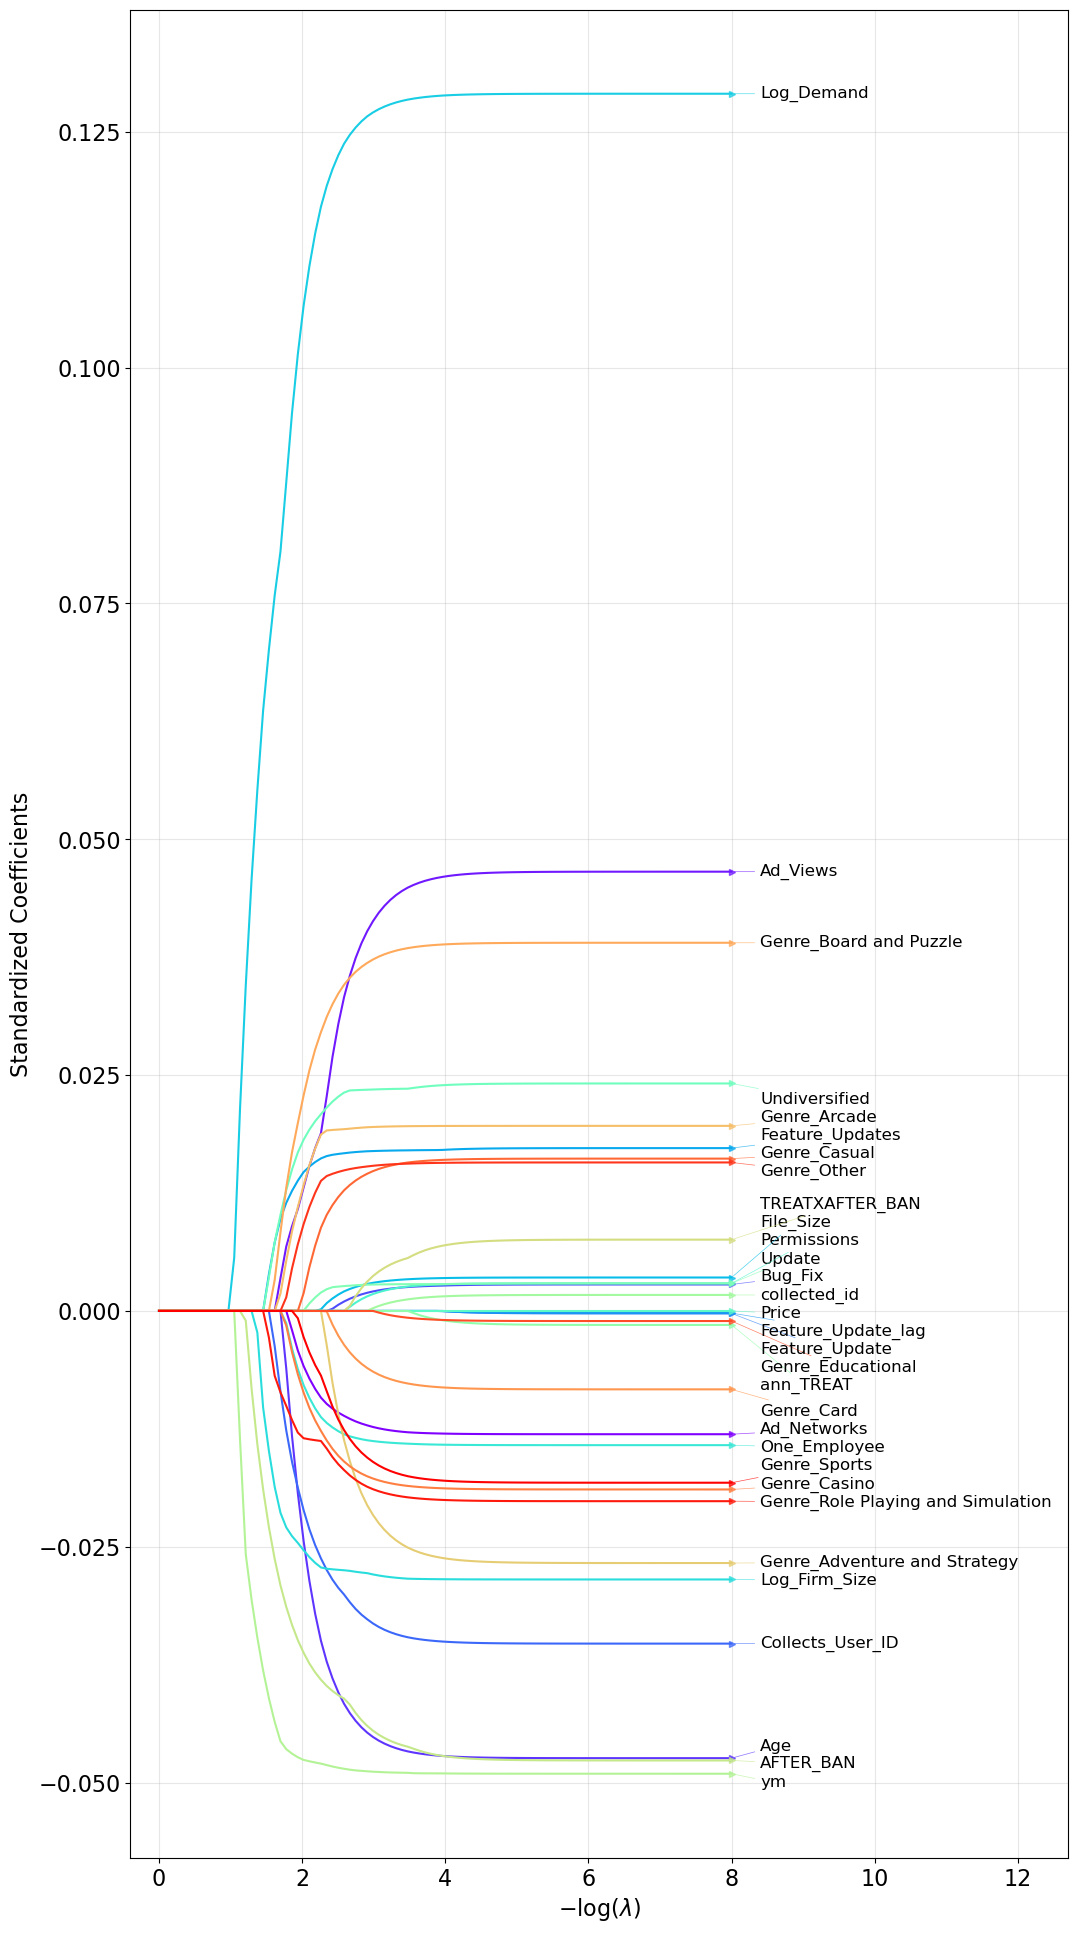

Plots have been saved to: C:\Users\azraj\OneDrive\Desktop\MA Economics\Fall Term\Causal ML\AdBanImpact\Figures


In [1000]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import enet_path, lasso_path
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")

def load_and_prepare_data(filepath):
    """Load and prepare the data for analysis"""
    df = pd.read_stata(filepath)
    
    # Create additional variables
    df['AFTER_BAN'] = (df['ym'] >= 716).astype(int)
    df['TREATXAFTER_BAN'] = df['ann_TREAT'] * df['AFTER_BAN']
    
    # Define the variables of interest
    selected_vars = [
        'Ad_Networks', 'Ad_Views', 'Age', 'Bug_Fix', 
        'Collects_User_ID', 'Feature_Update', 'Feature_Update_lag', 
        'Feature_Updates', 'File_Size', 'Log_Demand', 
        'Log_Firm_Size', 'One_Employee', 'Permissions', 
        'Price', 'Undiversified', 'Update', 'ann_TREAT', 
        'collected_id', 'genre_cons', 'ym', 
        'AFTER_BAN', 'TREATXAFTER_BAN', 'Rating'
    ]
    
    # Prepare dataset
    data = df[selected_vars].copy()
    data = pd.get_dummies(data, columns=['genre_cons'], drop_first=True)
    data.dropna(inplace=True)
    
    # Split features and target
    X = data.drop(columns=['Rating'])
    Y = data['Rating']
    
    return X, Y

def create_regression_plot(coef_df, save_path=None, is_lasso=False):
    """Create and display regression plot with detailed annotations and optional saving"""
    variable_numbers = {feature: i + 1 for i, feature in enumerate(coef_df.index)}
    
    def rename_feature(feature):
        if feature.startswith('genre_cons_'):
            return 'Genre_' + feature[11:]
        return feature
    
    # Parameters for annotation
    PROXIMITY_THRESHOLD = 0.0055
    MIN_HORIZONTAL_OFFSET = 0.4
    MAX_HORIZONTAL_OFFSET = 1.3
    VERTICAL_SPACING_FACTOR = 0.35
    
    plt.figure(figsize=(15, 24))
    plt.subplots_adjust(right=0.75)
    
    # Generate a color map for features
    colors = plt.cm.rainbow(np.linspace(0, 1, len(coef_df.index)))
    feature_colors = dict(zip(coef_df.index, colors))
    
    for feature in coef_df.index:
        color = feature_colors[feature]
        plt.plot(coef_df.columns, coef_df.loc[feature], linewidth=1.5, color=color)
        y_end = coef_df.loc[feature].iloc[-1]
        plt.plot(coef_df.columns[-1], y_end, '>', color=color, markersize=4, alpha=0.7)
    
    # Annotate with feature names
    x_tail = coef_df.columns[-1]
    y_values = [(feature, coef_df.loc[feature].iloc[-1]) for feature in coef_df.index]
    y_values.sort(key=lambda x: x[1])

    current_xlim = plt.gca().get_xlim()
    plt.xlim(current_xlim[0], current_xlim[1] + MAX_HORIZONTAL_OFFSET + 3)
    
    # Group close points for better readability
    groups = []
    current_group = []
    
    for feature, y_val in y_values:
        if not current_group:
            current_group = [(feature, y_val)]
        else:
            last_y = current_group[-1][1]
            if abs(y_val - last_y) < PROXIMITY_THRESHOLD:
                current_group.append((feature, y_val))
            else:
                groups.append(current_group)
                current_group = [(feature, y_val)]
    if current_group:
        groups.append(current_group)
    
    # Annotate grouped features
    for group in groups:
        n_points = len(group)
        if n_points == 1:
            feature, y_val = group[0]
            color = feature_colors[feature]
            plt.annotate(
                rename_feature(feature),
                xy=(x_tail, y_val),
                xytext=(x_tail + MIN_HORIZONTAL_OFFSET, y_val),
                fontsize=12,
                ha='left',
                va='center',
                color='black',
                arrowprops=dict(arrowstyle='-', color=color, alpha=0.7, linewidth=0.5)
            )
        else:
            base_y = sum(y[1] for y in group) / len(group)
            spacing = PROXIMITY_THRESHOLD * VERTICAL_SPACING_FACTOR
            for i, (feature, y_val) in enumerate(group):
                offset = (i - (n_points - 1) / 2) * spacing
                label_y = base_y + offset
                color = feature_colors[feature]
                plt.annotate(
                    rename_feature(feature),
                    xy=(x_tail, y_val),
                    xytext=(x_tail + MIN_HORIZONTAL_OFFSET, label_y),
                    fontsize=12,
                    ha='left',
                    va='center',
                    color='black',
                    arrowprops=dict(arrowstyle='-', color=color, alpha=0.7, linewidth=0.5)
                )
    
    # Reduce font size of x and y ticks
    plt.tick_params(axis='x', labelsize=16)
    plt.tick_params(axis='y', labelsize=16)
    
    plt.xlabel('$-\log(\lambda)$', fontsize=16)
    plt.ylabel('Standardized Coefficients', fontsize=16)
    plt.grid(True, alpha=0.3)
    
    # Save plot if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()

def run_ridge_regression(X_scaled, Y):
    """Run Ridge regression and return coefficients"""
    lambdas = 10 ** np.linspace(4, -5, 100)
    alphas, coefs, _ = enet_path(X_scaled, Y, l1_ratio=0.0, alphas=lambdas)
    return pd.DataFrame(coefs, index=X.columns, columns=-np.log10(alphas))

def run_lasso_regression(X_scaled, Y):
    """Run Lasso regression and return coefficients"""
    alphas_lasso = np.logspace(0, -8, 100)
    alphas_lasso, coefs_lasso, _ = lasso_path(X_scaled, Y, alphas=alphas_lasso, max_iter=10000)
    return pd.DataFrame(coefs_lasso, index=X.columns, columns=-np.log10(alphas_lasso))

# Load and prepare data
data_path = r"C:\Users\azraj\OneDrive\Desktop\MA Economics\Fall Term\Causal ML\AdBanImpact\at.dta"
X, Y = load_and_prepare_data(data_path)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set the path to save the figures
figures_path = r"C:\Users\azraj\OneDrive\Desktop\MA Economics\Fall Term\Causal ML\AdBanImpact\Figures"
os.makedirs(figures_path, exist_ok=True)

# Run Ridge regression and display/save plot
ridge_coef_df = run_ridge_regression(X_scaled, Y)
ridge_save_path = os.path.join(figures_path, 'ridge_regression_plot.png')
create_regression_plot(ridge_coef_df, save_path=ridge_save_path)

# Run Lasso regression and display/save plot
lasso_coef_df = run_lasso_regression(X_scaled, Y)
lasso_save_path = os.path.join(figures_path, 'lasso_regression_plot.png')
create_regression_plot(lasso_coef_df, save_path=lasso_save_path)

print("Plots have been saved to:", figures_path)
